In [1]:
import sys
import os
import subprocess
import types
import numpy as np
import imageio
import SimpleITK as sitk
import pandas as pd
import cv2
from skimage.transform import resize

# 1. Mock ProgressBar because it is missing
class MockProgressBar:
    FULL = 'full'
    def __init__(self, n, fmt='full'):
        self.n = n
        self.current = 0
    def __call__(self):
        pass
    def done(self):
        pass

# Inject into sys.modules so 'from ProgressBar import ProgressBar' works
mock_pb_module = types.ModuleType("ProgressBar")
mock_pb_module.ProgressBar = MockProgressBar
sys.modules["ProgressBar"] = mock_pb_module

# 2. Setup TensorFlow 1.x compatibility
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sys.modules['tensorflow'] = tf

# Add current directory to path to allow importing local modules
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

import GAN_tf
print("Setup complete.")



Instructions for updating:
non-resource variables are not supported in the long term
Setup complete.


# Loader for ACDC dataset

In [ ]:
def load_acdc_data(base_dir, target_size=(128, 192)):
    training_dir = os.path.join(base_dir, 'database', 'training_test')
    patients = sorted([d for d in os.listdir(training_dir) if os.path.isdir(os.path.join(training_dir, d))])

    all_images = []
    all_flows = []

    print(f"Found {len(patients)} patients.")

    for p in patients:
        p_dir = os.path.join(training_dir, p)
        cfg_path = os.path.join(p_dir, 'Info.cfg')
        if not os.path.exists(cfg_path):
            continue
            
        # Check group
        is_nor = False
        try:
            with open(cfg_path, 'r') as f:
                for line in f:
                    if line.strip().startswith('Group'):
                        if 'NOR' in line:
                            is_nor = True
                        break
        except Exception as e:
            print(f"Error reading config for {p}: {e}")
            continue
        
        if not is_nor:
            continue
            
        print(f"Processing {p} (NOR)...")
        # Load 4D
        nii_path = os.path.join(p_dir, f'{p}_4d.nii.gz')
        if not os.path.exists(nii_path):
             continue
             
        try:
            img_obj = sitk.ReadImage(nii_path)
            img_arr = sitk.GetArrayFromImage(img_obj) # (T, Z, Y, X) or similar. Normally ITK is (x,y,z,t) -> numpy (t,z,y,x)
        except Exception as e:
            print(f"Error loading image for {p}: {e}")
            continue

        if len(img_arr.shape) == 4:
            T, Z, H, W = img_arr.shape
        else:
             # Skip if not 4D
             print(f"Skipping {p}: Shape {img_arr.shape} is not 4D")
             continue
        
        for z in range(Z):
            slice_seq = img_arr[:, z, :, :]  # Shape: (T, H, W)
             
            # --- APPLIED FIX: Robust 1st/99th Percentile Normalization ---
            # 1. Calculate the 1st and 99th percentiles across the whole sequence
            p1 = np.percentile(slice_seq, 1)
            p99 = np.percentile(slice_seq, 99)
            
            # 2. Calculate the range (adding 1e-8 to prevent division by zero)
            slice_range = p99 - p1 + 1e-8

            # Pre-process frames for this slice
            processed_frames = []
            
            for t in range(T):
                frame = slice_seq[t]
            
                # 3. Resize the frame
                frame_resized = cv2.resize(
                    frame.astype(np.float32),
                    (target_size[1], target_size[0])
                )
                    
                # 4. Normalize using the percentiles (NOT the absolute min/max)
                # If the slice is completely empty/black, p99-p1 will be ~0
                if (p99 - p1) < 1e-7:
                    frame_norm = np.zeros(target_size, dtype=np.float32)
                else:
                    frame_norm = (frame_resized - p1) / slice_range
                    
                    # 5. Clip values strictly to [0.0, 1.0] 
                    # ANY outlier pixel brighter than p99 is now forced to exactly 1.0
                    # ANY outlier pixel darker than p1 is now forced to exactly 0.0
                    frame_norm = np.clip(frame_norm, 0.0, 1.0)

                frame_rgb = np.stack([frame_norm] * 3, axis=-1)
                processed_frames.append(frame_rgb)

            # ------------------------------
                    
            processed_frames_arr = np.array(processed_frames) # (T, 128, 192, 3)
             
            # Compute flows and pairs
            for t in range(T-1):
                prev_gray = (processed_frames_arr[t, :, :, 0] * 255).astype(np.uint8)
                next_gray = (processed_frames_arr[t+1, :, :, 0] * 255).astype(np.uint8)
                
                # Calc Dense Optical Flow
                try:
                    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                except Exception as e:
                    print(f"Flow failed: {e}")
                    continue

                # Add Magnitude channel
                mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                flow_3ch = np.dstack((flow, mag)) # (H, W, 3)
                
                all_images.append(processed_frames_arr[t]) 
                all_flows.append(flow_3ch)
                
    return np.array(all_images), np.array(all_flows)

# Loader for MM data

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import SimpleITK as sitk

def load_mm_data(mm_training_dir, csv_path, target_size=(128, 192)):
    """
    Load M&M (Multi-centre, Multi-vendor, Multi-disease) cardiac MRI data.
    Only subjects with Pathology == 'NOR' (normal) are loaded.

    Parameters
    ----------
    mm_training_dir : str
        Path to the M&M Training folder (Dataset_1/Training).
        Expected to contain files like {ID}_sa.nii.gz.
    csv_path : str
        Path to the M&M CSV metadata file
        (211230_M&Ms_Dataset_information_diagnosis_opendataset.csv).
    target_size : tuple
        (H, W) to which every frame is resized. Default matches load_acdc_data.

    Returns
    -------
    all_images : np.ndarray  shape (N, H, W, 3)
    all_flows  : np.ndarray  shape (N, H, W, 3)  [dx, dy, magnitude]
    """
    # Load CSV and build set of NOR subject IDs
    df = pd.read_csv(csv_path)
    nor_ids = set(df[df['Pathology'] == 'NOR']['External code'].tolist())
    print(f"Found {len(nor_ids)} M&M NOR subjects in CSV.")

    all_images = []
    all_flows  = []

    # Gather all short-axis volume files (skip ground-truth masks)
    sa_files = sorted([
        f for f in os.listdir(mm_training_dir)
        if f.endswith('_sa.nii.gz') and not f.endswith('_sa_gt.nii.gz')
    ])

    for fname in sa_files:
        subject_id = fname.replace('_sa.nii.gz', '')
        if subject_id not in nor_ids:
            continue

        print(f"Processing {subject_id} (M&M NOR)...")
        nii_path = os.path.join(mm_training_dir, fname)

        try:
            img_obj = sitk.ReadImage(nii_path)
            img_arr = sitk.GetArrayFromImage(img_obj)  # typically (T, Z, H, W)
        except Exception as e:
            print(f"Error loading {fname}: {e}")
            continue

        if len(img_arr.shape) == 4:
            T, Z, H, W = img_arr.shape
        else:
            print(f"Skipping {subject_id}: unexpected shape {img_arr.shape}")
            continue

        for z in range(Z):
            slice_seq = img_arr[:, z, :, :]  # (T, H, W)

            # --- APPLIED FIX: Robust 1st/99th Percentile Normalization ---
            p1 = np.percentile(slice_seq, 1)
            p99 = np.percentile(slice_seq, 99)
            slice_range = p99 - p1 + 1e-8

            processed_frames = []
            for t in range(T):
                frame = slice_seq[t]
                
                # Resize the frame first
                frame_resized = cv2.resize(
                    frame.astype(np.float32),
                    (target_size[1], target_size[0])
                )
                
                # Normalize using the percentiles
                if p99 - p1 == 0:
                    frame_norm = np.zeros(target_size)
                else:
                    frame_norm = (frame_resized - p1) / slice_range
                    # Clip values strictly to [0.0, 1.0] to crush extreme outliers
                    frame_norm = np.clip(frame_norm, 0.0, 1.0) 

                frame_rgb = np.stack([frame_norm] * 3, axis=-1)
                processed_frames.append(frame_rgb)

            processed_frames_arr = np.array(processed_frames)  # (T, H, W, 3)

            for t in range(T - 1):
                prev_gray = (processed_frames_arr[t,   :, :, 0] * 255).astype(np.uint8)
                next_gray = (processed_frames_arr[t+1, :, :, 0] * 255).astype(np.uint8)

                try:
                    flow = cv2.calcOpticalFlowFarneback(
                        prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0
                    )
                except Exception as e:
                    print(f"Flow failed for {subject_id} z={z} t={t}: {e}")
                    continue

                mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                flow_3ch = np.dstack((flow, mag))  # (H, W, 3)

                all_images.append(processed_frames_arr[t])
                all_flows.append(flow_3ch)

    return np.array(all_images), np.array(all_flows)


def load_combined_data(acdc_dir, mm_training_dir, csv_path, target_size=(128, 192)):
    """
    Load and concatenate NOR patients from both ACDC (Dataset_2) and
    M&M (Dataset_1) datasets.

    Parameters
    ----------
    acdc_dir       : str    root of Dataset_2 (contains 'database/training')
    mm_training_dir: str    Dataset_1/Training folder
    csv_path       : str    M&M CSV metadata file path
    target_size    : tuple  (H, W) resize target, default (128, 192)

    Returns
    -------
    images : np.ndarray  shape (N_acdc + N_mm, H, W, 3)
    flows  : np.ndarray  shape (N_acdc + N_mm, H, W, 3)
    """
    print("=== Loading ACDC NOR data ===")
    acdc_images, acdc_flows = load_acdc_data(acdc_dir, target_size)
    print(f"ACDC NOR samples: {len(acdc_images)}")

    print("\n=== Loading M&M NOR data ===")
    mm_images, mm_flows = load_mm_data(mm_training_dir, csv_path, target_size)
    print(f"M&M NOR samples:  {len(mm_images)}")

    if len(acdc_images) == 0 and len(mm_images) == 0:
        return np.array([]), np.array([])
    elif len(acdc_images) == 0:
        return mm_images, mm_flows
    elif len(mm_images) == 0:
        return acdc_images, acdc_flows

    images = np.concatenate([acdc_images, mm_images], axis=0)
    flows  = np.concatenate([acdc_flows,  mm_flows],  axis=0)
    print(f"\nCombined: {len(images)} samples total")
    return images, flows


## Trainings

In [6]:
# ── Combined ACDC + M&M training ────────────────────────────────────────────
acdc_dir       = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"
mm_training_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/Training"
mm_csv_path     = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"

try:
    images, flows = load_combined_data(acdc_dir, mm_training_dir, mm_csv_path)
    print(f"\nLoaded {len(images)} samples in total.")

    if len(images) > 0:
        print(f"Images shape: {images.shape}")
        print(f"Flows  shape: {flows.shape}")

        tf.compat.v1.reset_default_graph()

        print("\nStarting Training (ACDC + M&M combined)...")
        GAN_tf.train_Unet_naive_with_batch_norm(
            training_images=images,
            training_flows=flows,
            max_epoch=2,
            dataset_name='ACDC_MM_test',
            batch_size=4
        )
        print("Training complete.")
    else:
        print("No data loaded. Check dataset paths and NOR filtering.")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


=== Loading ACDC NOR data ===
Found 100 patients.
Processing patient061 (NOR)...
Processing patient062 (NOR)...
Processing patient063 (NOR)...
Processing patient064 (NOR)...
Processing patient065 (NOR)...
Processing patient066 (NOR)...
Processing patient067 (NOR)...
Processing patient068 (NOR)...
Processing patient069 (NOR)...
Processing patient070 (NOR)...
Processing patient071 (NOR)...
Processing patient072 (NOR)...
Processing patient073 (NOR)...
Processing patient074 (NOR)...
Processing patient075 (NOR)...
Processing patient076 (NOR)...
Processing patient077 (NOR)...
Processing patient078 (NOR)...
Processing patient079 (NOR)...
Processing patient080 (NOR)...
ACDC NOR samples: 4711

=== Loading M&M NOR data ===
Found 89 M&M NOR subjects in CSV.
Processing A2N8V0 (M&M NOR)...
Processing A3B7E5 (M&M NOR)...
Processing A3H1O5 (M&M NOR)...
Processing A4U9V5 (M&M NOR)...
Processing A8C9H8 (M&M NOR)...
Processing A8I1U6 (M&M NOR)...
Processing A9J8W7 (M&M NOR)...
Processing B1K7U1 (M&M NOR

c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:119: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:127: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  u = tf.layers.batch_normalization(u, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learn

Run: tensorboard --logdir logs/2
epoch 1/2, iter   1/4516: D_loss = 0.8009, G_loss = 0.8027, loss_appe = 0.7468, loss_flow = 0.2441
epoch 1/2, iter   2/4516: D_loss = 0.7998, G_loss = 0.7980, loss_appe = 0.6052, loss_flow = 0.2057


KeyboardInterrupt: 

In [3]:
# Parameters
base_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"

print("Loading ACDC Data...")

images, flows = load_acdc_data(base_dir)
print(f"Loaded {len(images)} samples.")


print(f"Images shape: {images.shape}")
print(f"Flows shape: {flows.shape}")

Loading ACDC Data...
Found 4 patients.
Processing patient061 (NOR)...
Processing patient062 (NOR)...
Loaded 551 samples.
Images shape: (551, 128, 192, 3)
Flows shape: (551, 128, 192, 3)


In [5]:
flows.max()

4.428835

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66076946..1.4430022].


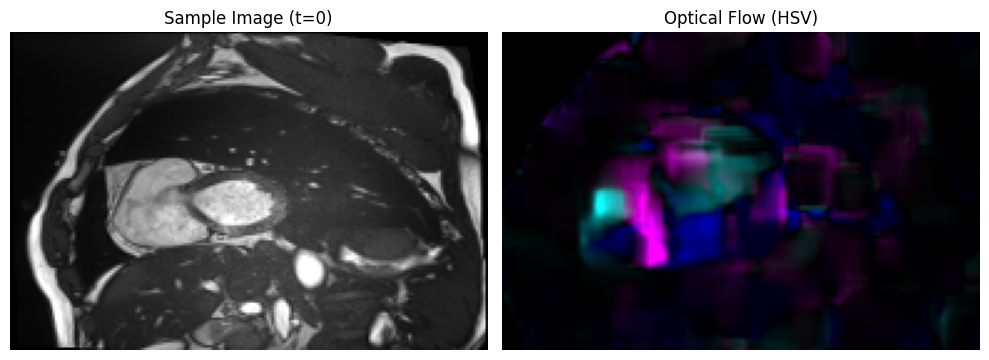

In [10]:
# visualize flow[0] and its images:
import matplotlib.pyplot as plt
# import mcolors for HSV to RGB conversion
import matplotlib.colors as mcolors

# Pick the first sample
sample_img = images[0]  # (128, 192, 3)
sample_flow = flows[0]   # (128, 192, 3) ->
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_img[..., 0], cmap='gray')  # Show the
axes[0].set_title("Sample Image (t=0)")
axes[0].axis('off')
axes[1].imshow(sample_flow)
axes[1].set_title("Optical Flow (HSV)")
axes[1].axis('off')
plt.tight_layout()
plt.show()


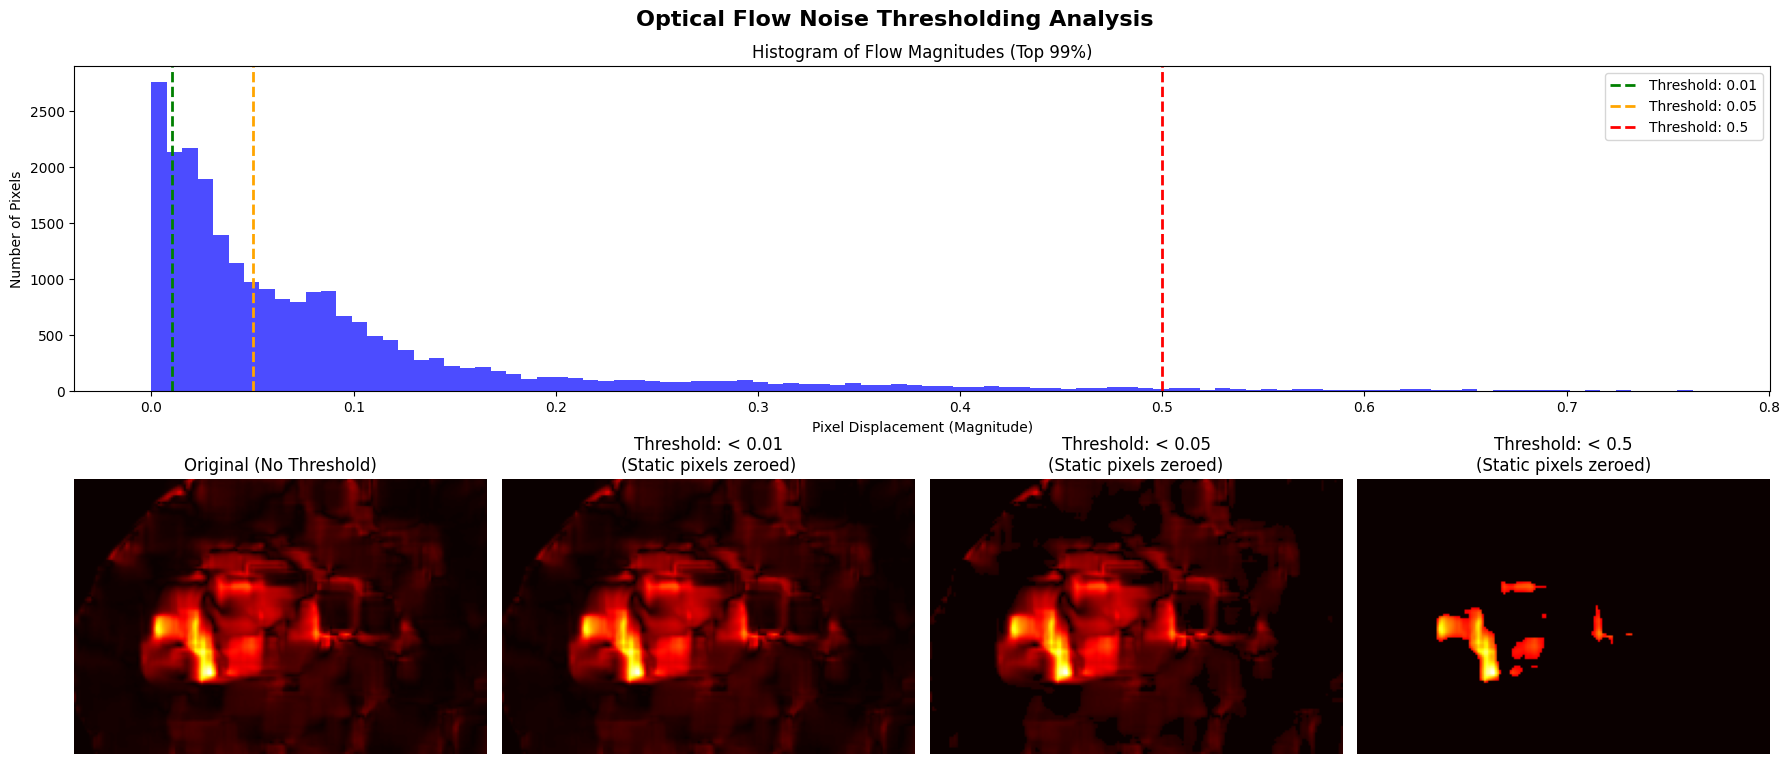

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_flow_thresholds(flow_3ch):
    """
    Plots a histogram of flow magnitudes and compares different noise thresholds.
    Assumes flow_3ch is shape (H, W, 3) where index 2 is the magnitude.
    """
    # Extract just the magnitude channel
    mag = flow_3ch[..., 2]
    
    # Define the thresholds we want to test
    thresholds = [0.01, 0.05, 0.5]
    
    # Create the figure layout
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Optical Flow Noise Thresholding Analysis", fontsize=16, fontweight='bold')

    # --- Plot 1: The Histogram ---
    # 
    ax_hist = plt.subplot(2, 4, (1, 4)) # Span the top row
    ax_hist.hist(mag.flatten(), bins=100, range=(0.0, np.percentile(mag, 99)), color='blue', alpha=0.7)
    ax_hist.set_title("Histogram of Flow Magnitudes (Top 99%)")
    ax_hist.set_xlabel("Pixel Displacement (Magnitude)")
    ax_hist.set_ylabel("Number of Pixels")
    
    # Draw vertical lines for our thresholds on the histogram
    colors = ['green', 'orange', 'red']
    for t, c in zip(thresholds, colors):
        ax_hist.axvline(x=t, color=c, linestyle='dashed', linewidth=2, label=f'Threshold: {t}')
    ax_hist.legend()

    # --- Plot 2: Original Flow Magnitude ---
    ax_orig = plt.subplot(2, 4, 5)
    ax_orig.imshow(mag, cmap='hot')
    ax_orig.set_title("Original (No Threshold)")
    ax_orig.axis('off')

    # --- Plots 3, 4, 5: Thresholded Flows ---
    # 
    for i, (t, c) in enumerate(zip(thresholds, colors)):
        ax_thresh = plt.subplot(2, 4, 6 + i)
        
        # Apply the threshold logically: if less than t, set to 0.0, else keep original
        clean_mag = np.where(mag < t, 0.0, mag)
        
        ax_thresh.imshow(clean_mag, cmap='hot')
        ax_thresh.set_title(f"Threshold: < {t}\n(Static pixels zeroed)")
        ax_thresh.axis('off')

    plt.tight_layout()
    plt.show()

# --- How to use it ---
# Assuming 'all_flows' is the array returned by your loading function:
# Pick a frame where the heart is actively moving (e.g., frame 10 or 15)
visualize_flow_thresholds(flows[0])

In [5]:
flows

array([], dtype=float64)

In [3]:
# Parameters
base_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"

print("Loading ACDC Data...")
try:
    images, flows = load_acdc_data(base_dir)
    print(f"Loaded {len(images)} samples.")
    
    if len(images) > 0:
        print(f"Images shape: {images.shape}")
        print(f"Flows shape: {flows.shape}")
        
        # To reset defaul graph, this is something from tensorflow1
        tf.compat.v1.reset_default_graph() 
        
        # Train
        print("Starting Training...")
        GAN_tf.train_Unet_naive_with_batch_norm(
            training_images=images,
            training_flows=flows,
            max_epoch=2,
            dataset_name='ACDC_test',
            batch_size=4
        )
        print("Training complete.")
    else:
        print("No data loaded. Check paths and group='NOR'.")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Loading ACDC Data...
Found 4 patients.
Processing patient061 (NOR)...
Processing patient062 (NOR)...
Loaded 551 samples.
Images shape: (551, 128, 192, 3)
Flows shape: (551, 128, 192, 3)

Starting Training...
no. of images = 551


Instructions for updating:
Colocations handled automatically by placer.


c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:145: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:153: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  u = tf.layers.batch_normalization(u, training=training)
c:\Users\Usuario\Desktop\MRes AI and Machine Learning\MRes_Project\Anomaly_detection_ICCV2019\GAN_tf.py:202: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  d = tf.layers.batch_normalization(d, training=training)




Run: tensorboard --logdir logs/2
epoch 1/2, iter   1/138: D_loss = 0.8036, G_loss = 0.8039, loss_appe = 1.0077, loss_flow = 0.2648
epoch 1/2, iter   2/138: D_loss = 0.8031, G_loss = 0.8020, loss_appe = 0.8826, loss_flow = 0.2204
epoch 1/2, iter   3/138: D_loss = 0.8014, G_loss = 0.7976, loss_appe = 0.7193, loss_flow = 0.1786
epoch 1/2, iter   4/138: D_loss = 0.8007, G_loss = 0.7957, loss_appe = 0.5925, loss_flow = 0.1508
epoch 1/2, iter   5/138: D_loss = 0.8003, G_loss = 0.7953, loss_appe = 0.5121, loss_flow = 0.1427
epoch 1/2, iter   6/138: D_loss = 0.7998, G_loss = 0.7908, loss_appe = 0.4185, loss_flow = 0.1268
epoch 1/2, iter   7/138: D_loss = 0.8017, G_loss = 0.7957, loss_appe = 0.4505, loss_flow = 0.1228
epoch 1/2, iter   8/138: D_loss = 0.7990, G_loss = 0.7916, loss_appe = 0.3817, loss_flow = 0.1225
epoch 1/2, iter   9/138: D_loss = 0.8029, G_loss = 0.7968, loss_appe = 0.4171, loss_flow = 0.1050
epoch 1/2, iter  10/138: D_loss = 0.7997, G_loss = 0.7925, loss_appe = 0.3545, loss

KeyboardInterrupt: 

## Using only ES and ED

In [ ]:
# ── ED/ES-only combined data loader ──────────────────────────────────────────
# Loads NOR subjects from ACDC (Dataset_2) and M&M (Dataset_1).
# For each subject and each z-slice:
#   • input image  = End-Systole (ES) frame
#   • next frame   = End-Diastole (ED) frame
# Optical flow is computed from ES → ED.

def load_combined_ed_es_data(acdc_dir, mm_training_dir, csv_path,
                              target_size=(128, 192)):
    """
    Load only End-Diastole (ED) and End-Systole (ES) frame pairs
    from both ACDC (Dataset_2) and M&M (Dataset_1) NOR subjects.

    Parameters
    ----------
    acdc_dir        : str   Root of Dataset_2 (contains 'database/training').
    mm_training_dir : str   Dataset_1/Training folder.
    csv_path        : str   M&M CSV metadata file path.
    target_size     : tuple (H, W) resize target, default (128, 192).

    Returns
    -------
    all_images : np.ndarray  shape (N, H, W, 3)  – ES frames (input)
    all_flows  : np.ndarray  shape (N, H, W, 3)  – optical flow ES→ED
    """

    def _preprocess_frame(frame, p1, p99, target_size):
        """Resize + percentile-normalise a single 2-D frame to RGB."""
        frame_resized = cv2.resize(
            frame.astype(np.float32),
            (target_size[1], target_size[0])
        )
        if (p99 - p1) < 1e-7:
            frame_norm = np.zeros(target_size, dtype=np.float32)
        else:
            frame_norm = np.clip((frame_resized - p1) / (p99 - p1 + 1e-8),
                                 0.0, 1.0)
        return np.stack([frame_norm] * 3, axis=-1)  # (H, W, 3)

    all_images = []
    all_flows  = []

    # ── ACDC ────────────────────────────────────────────────────────────────
    training_dir = os.path.join(acdc_dir, 'database', 'training')
    if not os.path.isdir(training_dir):
        # fallback used by earlier experiments
        training_dir = os.path.join(acdc_dir, 'database', 'training_test')
    patients = sorted([d for d in os.listdir(training_dir)
                       if os.path.isdir(os.path.join(training_dir, d))])
    print(f"ACDC: found {len(patients)} patient folders.")

    for p in patients:
        p_dir    = os.path.join(training_dir, p)
        cfg_path = os.path.join(p_dir, 'Info.cfg')
        if not os.path.exists(cfg_path):
            continue

        # Read Group, ED, ES from Info.cfg
        info = {}
        try:
            with open(cfg_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if ':' in line:
                        key, val = line.split(':', 1)
                        info[key.strip()] = val.strip()
        except Exception as e:
            print(f"Cannot read config for {p}: {e}")
            continue

        if info.get('Group', '') != 'NOR':
            continue

        try:
            ed_idx = int(info['ED'])
            es_idx = int(info['ES'])
        except (KeyError, ValueError) as e:
            print(f"Missing ED/ES in {p}: {e}")
            continue

        nii_path = os.path.join(p_dir, f'{p}_4d.nii.gz')
        if not os.path.exists(nii_path):
            continue

        try:
            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(nii_path))  # (T,Z,H,W)
        except Exception as e:
            print(f"Load error {p}: {e}")
            continue

        if img_arr.ndim != 4:
            continue
        T, Z, _, _ = img_arr.shape

        if es_idx >= T or ed_idx >= T:
            print(f"Skipping {p}: ED={ed_idx} or ES={es_idx} out of range T={T}")
            continue

        print(f"ACDC {p} (NOR)  ED={ed_idx}  ES={es_idx}")
        for z in range(Z):
            slice_seq = img_arr[:, z, :, :]  # (T, H, W)
            p1  = np.percentile(slice_seq, 1)
            p99 = np.percentile(slice_seq, 99)

            es_frame_rgb = _preprocess_frame(slice_seq[es_idx], p1, p99, target_size)
            ed_frame_rgb = _preprocess_frame(slice_seq[ed_idx], p1, p99, target_size)

            es_gray = (es_frame_rgb[:, :, 0] * 255).astype(np.uint8)
            ed_gray = (ed_frame_rgb[:, :, 0] * 255).astype(np.uint8)

            try:
                flow = cv2.calcOpticalFlowFarneback(
                    es_gray, ed_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            except Exception as e:
                print(f"Flow error {p} z={z}: {e}")
                continue

            mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            flow_3ch = np.dstack((flow, mag))  # (H, W, 3)

            all_images.append(es_frame_rgb)
            all_flows.append(flow_3ch)

    print(f"ACDC NOR ED/ES samples: {len(all_images)}")
    acdc_count = len(all_images)

    # ── M&M ─────────────────────────────────────────────────────────────────
    df = pd.read_csv(csv_path)
    # Build lookup: subject_id -> (ed_idx, es_idx)
    nor_rows = df[df['Pathology'] == 'NOR'][['External code', 'ED', 'ES']]
    nor_info = {row['External code']: (int(row['ED']), int(row['ES']))
                for _, row in nor_rows.iterrows()}
    print(f"M&M: found {len(nor_info)} NOR subjects in CSV.")

    sa_files = sorted([f for f in os.listdir(mm_training_dir)
                       if f.endswith('_sa.nii.gz') and not f.endswith('_sa_gt.nii.gz')])

    for fname in sa_files:
        subject_id = fname.replace('_sa.nii.gz', '')
        if subject_id not in nor_info:
            continue

        ed_idx, es_idx = nor_info[subject_id]
        nii_path = os.path.join(mm_training_dir, fname)

        try:
            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(nii_path))  # (T,Z,H,W)
        except Exception as e:
            print(f"Load error {subject_id}: {e}")
            continue

        if img_arr.ndim != 4:
            continue
        T, Z, _, _ = img_arr.shape

        if es_idx >= T or ed_idx >= T:
            print(f"Skipping {subject_id}: ED={ed_idx} or ES={es_idx} out of range T={T}")
            continue

        print(f"M&M {subject_id} (NOR)  ED={ed_idx}  ES={es_idx}")
        for z in range(Z):
            slice_seq = img_arr[:, z, :, :]  # (T, H, W)
            p1  = np.percentile(slice_seq, 1)
            p99 = np.percentile(slice_seq, 99)

            es_frame_rgb = _preprocess_frame(slice_seq[es_idx], p1, p99, target_size)
            ed_frame_rgb = _preprocess_frame(slice_seq[ed_idx], p1, p99, target_size)

            es_gray = (es_frame_rgb[:, :, 0] * 255).astype(np.uint8)
            ed_gray = (ed_frame_rgb[:, :, 0] * 255).astype(np.uint8)

            try:
                flow = cv2.calcOpticalFlowFarneback(
                    es_gray, ed_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            except Exception as e:
                print(f"Flow error {subject_id} z={z}: {e}")
                continue

            mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            flow_3ch = np.dstack((flow, mag))

            all_images.append(es_frame_rgb)
            all_flows.append(flow_3ch)

    mm_count = len(all_images) - acdc_count
    print(f"M&M NOR ED/ES samples: {mm_count}")
    print(f"Combined ED/ES samples: {len(all_images)}")

    if len(all_images) == 0:
        return np.array([]), np.array([])
    return np.array(all_images), np.array(all_flows)


In [ ]:
# ── Train on combined ED/ES pairs (ES → ED) ──────────────────────────────────
# Input  : End-Systole  (ES) frame per z-slice
# Target : End-Diastole (ED) frame per z-slice  (used as "next frame" by GAN)
# Flow   : optical flow computed ES → ED

acdc_dir        = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_2"
mm_training_dir = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/Training"
mm_csv_path     = r"C:/Users/Usuario/Desktop/MRes AI and Machine Learning/MRes_Project/Dataset_1/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"

try:
    images_ed_es, flows_ed_es = load_combined_ed_es_data(
        acdc_dir, mm_training_dir, mm_csv_path
    )
    print(f"\nLoaded {len(images_ed_es)} ED/ES samples in total.")

    if len(images_ed_es) > 0:
        print(f"Images shape : {images_ed_es.shape}")
        print(f"Flows  shape : {flows_ed_es.shape}")

        tf.compat.v1.reset_default_graph()

        print("\nStarting Training (ED/ES combined, ES→ED)...")
        GAN_tf.train_Unet_naive_with_batch_norm(
            training_images=images_ed_es,
            training_flows=flows_ed_es,
            max_epoch=2,
            dataset_name='ACDC_MM_EDES', 
            batch_size=4
        )
        print("Training complete.")
    else:
        print("No data loaded. Check dataset paths and NOR filtering.")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
